### Бутстрэп

Давайте для примера возьмем уже известный вам набор данных telecom_churn из прошлых уроков нашего курса. Напомним, что это задача бинарной классификации оттока клиентов. Одним из самых важных признаков в этом датасете является количество звонков в сервисный центр, которые были сделаны клиентом. Давайте попробуем визулизировать данные и посмотреть на распределение данного признака.

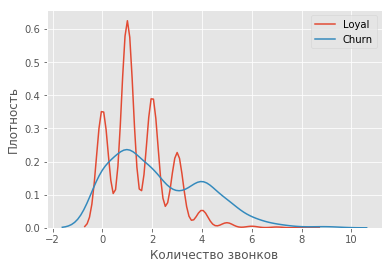

In [11]:
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
import seaborn as sns
%matplotlib inline

telecom_data = pd.read_csv('../data/telecom_churn.csv')

fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == False]['Customer service calls'], label='Loyal')
fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == True]['Customer service calls'], label='Churn')
fig.set(xlabel='Количество звонков', ylabel='Плотность') 
plt.show()

Как вы уже могли заметить, количество звонков в сервисный центр у лояльных клиентов меньше, чем у наших бывших клиентов. Теперь было бы хорошо оценить, сколько в среднем делает звонков каждая из групп. Так как данных в нашем датасете мало, то искать среднее не совсем правильно, лучше применить наши новые знания бутстрэпа. Давайте сгенерируем 1000 новых подвыборок из нашей генеральной совокупности и сделаем интервальную оценку среднего.

#### Код для построения доверительного интервала с помощью бутстрэпа

In [12]:
import numpy as np
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [47]:
# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам
loyal_calls = telecom_data[telecom_data['Churn'] == False]['Customer service calls'].values
churn_calls = telecom_data[telecom_data['Churn'] == True]['Customer service calls'].values

In [49]:
# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем выборки с помощью бутстрэпа и сразу считаем по каждой из них среднее
loyal_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(loyal_calls, 1000)]
churn_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(churn_calls, 1000)]

In [52]:
#  выводим интервальную оценку среднего
print('Service calls from loyal: mean interval', stat_intervals(loyal_mean_scores, 0.05))
print('Service calls from churn: mean interval', stat_intervals(churn_mean_scores, 0.05))

Service calls from loyal: mean interval [1.4077193  1.49473684]
Service calls from churn: mean interval [2.0621118  2.39761905]


В итоге мы получили, что с 95% вероятностью среднее число звонков от лояльных клиентов будет лежать в промежутке между 1.40 и 1.50, в то время как наши бывшие клиенты звонили в среднем от 2.06 до 2.40 раз. Также ещё можно обратить внимание, что интервал для лояльных клиентов уже, что довольно логично, так как они звонят редко (в основном 0, 1 или 2 раза), а недовольные клиенты будут звонить намного чаще, но со временем их терпение закончится, и они поменяют оператора.

### Бэггинг

Теперь вы имеете представление о бутстрэпе, и мы можем перейти непосредственно к бэггингу. Пусть имеется обучающая выборка $X$. С помощью бутстрэпа сгенерируем из неё выборки $X_1,...,X_M$. Теперь на каждой выборке обучим свой классификатор $a_i(x)$. Итоговый классификатор будет усреднять ответы всех этих алгоритмов (в случае классификации это соответствует голосованию): $a(x)=\frac{1}{M} \sum^M_{i=1} a_i(x) $.

**Бэггинг** позволяет снизить **дисперсию (variance)** обучаемого классификатора, уменьшая величину, на сколько ошибка будет отличаться, если обучать модель на разных наборах данных, или другими словами, **предотвращает переобучение**. Эффективность бэггинга достигается благодаря тому, что базовые алгоритмы, обученные по различным подвыборкам, получаются достаточно различными, и их ошибки взаимно компенсируются при голосовании, а также за счёт того, что объекты-выбросы могут не попадать в некоторые обучающие подвыборки.

В библиотеке scikit-learn есть реализации BaggingRegressor и BaggingClassifier, которые позволяют использовать большинство других алгоритмов "внутри". Рассмотрим на практике, как работает бэггинг, и сравним его с деревом решений, пользуясь примером из документации:

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


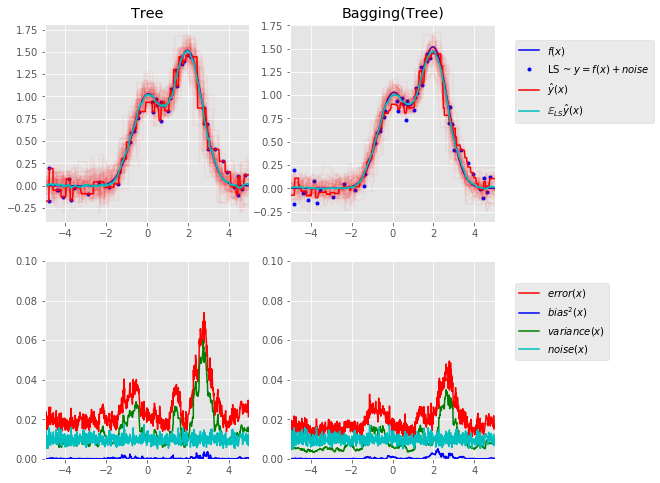

In [58]:
# http://scikit-learn.org/stable/auto_examples/ensemble/
# plot_bias_variance.html#sphx-glr-auto-examples-ensemble-plot-bias-variance-py

# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y


X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{LS} \^y(x)$")

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

По графику и результатам выше видно, что **ошибка дисперсии намного меньше при бэггинге**.

Бэггинг эффективен на малых выборках, когда исключение даже малой части обучающих объектов приводит к построению существенно различных базовых классификаторов. В случае больших выборок обычно генерируют подвыборки существенно меньшей длины.

Следует отметить, что рассмотренный нами пример не очень применим на практике, поскольку мы сделали предположение о некоррелированности ошибок, что редко выполняется. Если это предположение неверно, то уменьшение ошибки оказывается не таким значительным.

### Случайный лес

Решающие деревья являются хорошим семейством базовых классификаторов для бэггинга, поскольку они достаточно сложны и могут достигать нулевой ошибки на любой выборке. Метод случайных подпространств позволяет снизить коррелированность между деревьями и избежать переобучения. Базовые алгоритмы обучаются на различных подмножествах признакового описания, которые также выделяются случайным образом.

Случайный лес — это бэггинг над решающими деревьями, при обучении которых для каждого разбиения признаки выбираются из некоторого случайного подмножества признаков.

### Сравнение с деревом решений и бэггингом

In [85]:
%pylab inline
np.random.seed(42)
figsize(8, 6)
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

n_train = 150        
n_test = 1000       
noise = 0.1

Populating the interactive namespace from numpy and matplotlib


/Users/olga/Projects/Extruder/venv/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [86]:
# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

In [87]:
X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

Text(0.5,1,'Решающее дерево, MSE = 19.34')

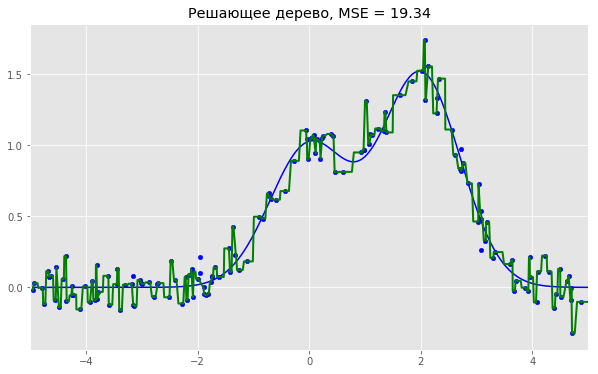

In [88]:
# One decision tree regressor
dtree = DecisionTreeRegressor().fit(X_train, y_train)
d_predict = dtree.predict(X_test)

plt.figure(figsize=(10,6))
plt.plot(X_test, f(X_test), 'b')
plt.scatter(X_train, y_train, c='b', s=20)
plt.plot(X_test, d_predict, 'g', lw=2)
plt.xlim([-5, 5])
plt.title('Решающее дерево, MSE = %.2f' % np.sum((y_test - d_predict) **2))

Text(0.5,1,'Бэггинг решающих деревьев, MSE = 14.70')

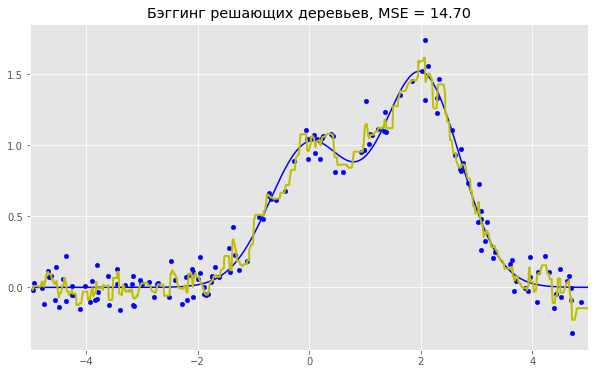

In [89]:
# Bagging decision tree regressor
bdt = BaggingRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
bdt_predict = bdt.predict(X_test)

plt.figure(figsize=(10,6))
plt.plot(X_test, f(X_test), 'b')
plt.scatter(X_train, y_train, c='b', s=20)
plt.plot(X_test, bdt_predict, 'y', lw=2)
plt.xlim([-5, 5])
plt.title('Бэггинг решающих деревьев, MSE = %.2f' % np.sum((y_test - bdt_predict) **2))

Text(0.5,1,'Случайный лес, MSE = 14.07')

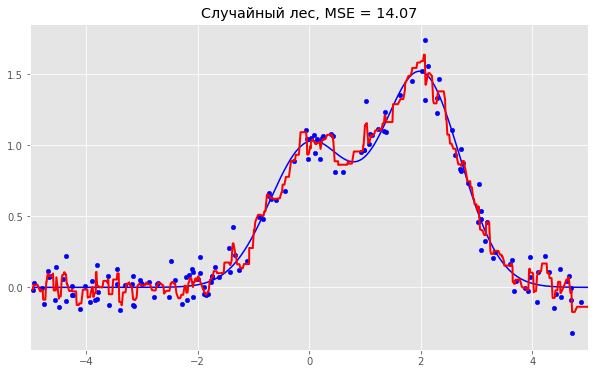

In [90]:
# Random Forest
rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
rf_predict = rf.predict(X_test)

plt.figure(figsize=(10,6))
plt.plot(X_test, f(X_test), 'b')
plt.scatter(X_train, y_train, c='b', s=20)
plt.plot(X_test, rf_predict, 'r', lw=2)
plt.xlim([-5, 5])
plt.title('Случайный лес, MSE = %.2f' % np.sum((y_test - rf_predict) **2))

Как мы видим из графиков и значений ошибки MSE, **случайный лес из 10 деревьев дает лучший результат, чем одно дерево или бэггинг из 10 деревьев решений**. Основное различие случайного леса и бэггинга на деревьях решений заключается в том, что в случайном лесе выбирается **случайное подмножество признаков**, и лучший признак для разделения узла определяется из подвыборки признаков, в отличие от бэггинга, где все функции рассматриваются для разделения в узле.

### Параметры

In [ ]:
class sklearn.ensemble.RandomForestRegressor(
    n_estimators — число деревьев в "лесу" (по дефолту – 10)
    criterion — функция, которая измеряет качество разбиения ветки дерева (по дефолту — "mse" , так же можно выбрать "mae")
    max_features — число признаков, по которым ищется разбиение. Вы можете указать конкретное число или процент признаков, 
                    либо выбрать из доступных значений: "auto" (все признаки), "sqrt", "log2". По дефолту стоит "auto".
    max_depth — максимальная глубина дерева  (по дефолту глубина не ограничена)
    min_samples_split — минимальное количество объектов, необходимое для разделения внутреннего узла. 
                        Можно задать числом или процентом от общего числа объектов (по дефолту — 2)
    min_samples_leaf — минимальное число объектов в листе. Можно задать числом или процентом от общего числа объектов (по дефолту — 1)
    min_weight_fraction_leaf — минимальная взвешенная доля от общей суммы весов (всех входных объектов) 
                                                                    должна быть в листе (по дефолту имеют одинаковый вес)
    max_leaf_nodes — максимальное количество листьев (по дефолту нет ограничения)
    min_impurity_split — порог для остановки наращивания дерева (по дефолту 1е-7)
    bootstrap — применять ли бустрэп для построения дерева (по дефолту True)
    oob_score — использовать ли out-of-bag объекты для оценки R^2 (по дефолту False)
    n_jobs — количество ядер для построения модели и предсказаний (по дефолту 1, если поставить -1, то будут использоваться все ядра)
    random_state — начальное значение для генерации случайных чисел 
                                (по дефолту его нет, если хотите воспроизводимые результаты, то нужно указать любое число типа int
    verbose — вывод логов по построению деревьев (по дефолту 0)
    warm_start — использует уже натренированую модель и добавляет деревьев в ансамбль (по дефолту False)
)

In [ ]:
class sklearn.ensemble.RandomForestClassifier(
    criterion — поскольку у нас теперь задача классификации, то по дефолту выбран критерий "gini" (можно выбрать "entropy")
    class_weight — вес каждого класса (по дефолту все веса равны 1, но можно передать словарь с весами, 
                        либо явно указать "balanced", тогда веса классов будут равны их исходным частям в генеральной совокупности; 
                        также можно указать "balanced_subsample", тогда веса на каждой подвыборке будут меняться в зависимости 
                                       от распределения классов на этой подвыборке.
)

#### Рассмотрим применение случайного леса в реальной задаче

Для этого будем использовать пример с задачей оттока клиентов. Это задача классификации, поэтому будем использовать метрику accuracy для оценки качества модели. Для начала построим самый простой классификатор, который будет нашим бейслайном. Возьмем только числовые признаки для упрощения.

In [93]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

In [95]:
# Загружаем данные
df = pd.read_csv('../data/telecom_churn.csv')

# Выбираем сначала только колонки с числовым типом данных
cols = []
for i in df.columns:
    if (df[i].dtype == 'float64') or (df[i].dtype == 'int64'):
        cols.append(i)
        
# Разделяем на признаки и объекты
X, y = df[cols].copy(), np.asarray(df["Churn"], dtype='int8')

# Инициализируем стратифицированную разбивку нашего датасета для валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Инициализируем наш классификатор с дефолтными параметрами
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

# Обучаем на тренировочном датасете
results = cross_val_score(rfc, X, y, cv=skf)

# Оцениваем долю верных ответов на тестовом датасете
print('CV accuracy score: {:.2f}%'.format(results.mean()*100))

/Users/olga/Projects/Extruder/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/olga/Projects/Extruder/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/olga/Projects/Extruder/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/olga/Projects/Extruder/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/olga/Projects/Extruder/venv/lib/python3.6/site-packag

CV accuracy score: 91.48%


/Users/olga/Projects/Extruder/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/olga/Projects/Extruder/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [119]:
len(cols)

16

Теперь попробуем улучшить этот результат и посмотреть, как ведут себя кривые валидации при изменении основных параметров.

**Начнем с количества деревьев:**

In [134]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

In [135]:
# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        rfc.fit(X_train, y_train)
        
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print('Best acc on CV is {:.2f}% with {} trees'.format(max(test_acc.mean(axis=1))*100,
                                                       trees_grid[np.argmax(test_acc.mean)]))

Best acc on CV is 92.44% with 5 trees


In [100]:
test_acc

array([[0.90554723, 0.91304348, 0.91004498, 0.90690691, 0.89489489],
       [0.91604198, 0.91904048, 0.91754123, 0.91741742, 0.9039039 ],
       [0.92353823, 0.92353823, 0.92503748, 0.92042042, 0.9039039 ],
       [0.92353823, 0.92503748, 0.92953523, 0.91591592, 0.90840841],
       [0.92653673, 0.93403298, 0.93103448, 0.91891892, 0.90840841],
       [0.93103448, 0.93403298, 0.93103448, 0.91741742, 0.90840841],
       [0.92653673, 0.93103448, 0.93253373, 0.91741742, 0.91291291],
       [0.92503748, 0.92953523, 0.93403298, 0.91741742, 0.91441441]])

Text(0.5,0,'N_estimators')

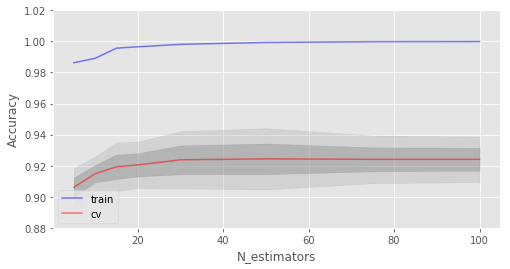

In [102]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

Начнем с параметра максимальной глубины – max_depth. (зафиксируем к-во деревьев 100)

In [103]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

In [105]:
# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

In [108]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)

In [110]:
print('Best acc on CV is {:.2f}% with {} max_depth'.format(max(test_acc.mean(axis=1))*100,
                                                           max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

Best acc on CV is 92.68% with 17 max_depth


Text(0.5,0,'Max_depth')

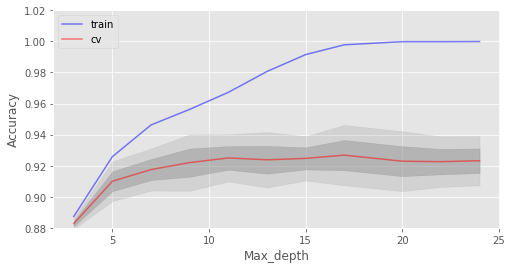

In [111]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth")

Еще важный параметр min_samples_leaf, он также выполняет функцию регуляризатора.

In [112]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.41% with 3 min_samples_leaf


Text(0.5,0,'Min_samples_leaf')

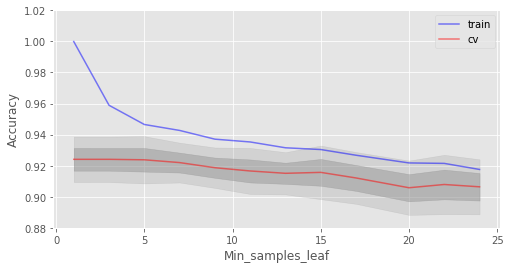

In [113]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf")

В данном случае мы не выигрываем в точности на валидации, но зато можем сильно уменьшить переобучение до 2% при сохранении точности около 92%.

Рассмотрим такой параметр как max_features. Для задач классификации по умолчанию используется $\sqrt{n}$, где n — число признаков. Давайте проверим, оптимально ли в нашем случае использовать 4 признака или нет.

In [120]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

# Обучаем на тренировочном датасете
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.59% with 12 max_features


Text(0.5,0,'Max_features')

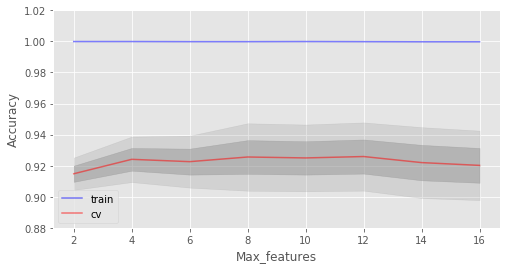

In [121]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features")

В нашем случае оптимальное число признаков — 12, именно с таким значением достигается наилучший результат.

Мы рассмотрели, как ведут себя кривые валидации в зависимости от изменения основных параметров. Давайте теперь с помощью GridSearchCV найдем оптимальные параметры для нашего примера.

In [122]:
# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'max_features': [4, 7, 10, 12], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,17,20]}
rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  1.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [4, 7, 10, 12], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5, 10, 17, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [124]:
gcv.best_params_, gcv.best_score_

({'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 1},
 0.9270927092709271)

Лучшая доля верных ответов, который мы смогли достичь с помощью перебора параметров — 92.71% при 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 1.

### Оценка важности признаков

Рассмотрим результаты анкетирования посетителей хостелов с сайтов Booking.com и TripAdvisor.com. Признаки — средние оценки по разным факторам (перечислены ниже) — персонал, состояние комнат и т.д. Целевой признак — рейтинг хостела на сайте.

Populating the interactive namespace from numpy and matplotlib
Feature ranking:
1. Персонал 0.182757 
2. Цена/качество 0.148373 
3. Состояние общего пространства 0.128296 
4. Дополнительные услуги 0.116604 
5. ССЦ 0.106668 
6. Общие условия и удобства 0.088589 
7. Состояние общей кухни 0.074273 
8. Заезд в хостел и выезд из хостела 0.061521 
9. Бронирование хостела  0.053615 
10. Состояние комнаты 0.039305 


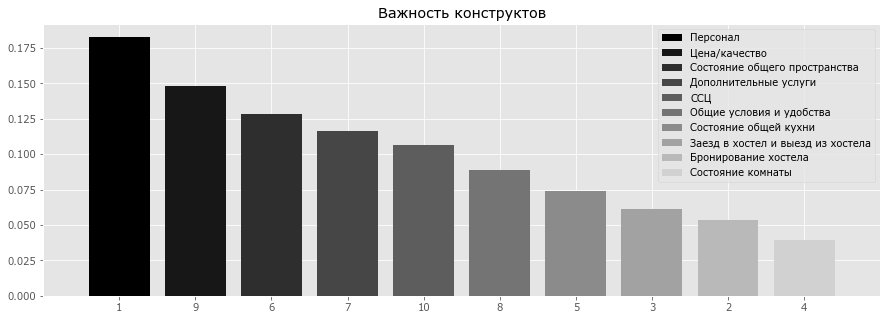

In [130]:
%pylab inline
import seaborn as sns
# russian headres
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)
import pandas as pd
import numpy as np
from sklearn.ensemble.forest import RandomForestRegressor

hostel_data = pd.read_csv("../data/hostel_factors.csv")
features = {"f1":u"Персонал",
"f2":u"Бронирование хостела ",
"f3":u"Заезд в хостел и выезд из хостела",
"f4":u"Состояние комнаты",
"f5":u"Состояние общей кухни",
"f6":u"Состояние общего пространства",
"f7":u"Дополнительные услуги",
"f8":u"Общие условия и удобства",
"f9":u"Цена/качество",
"f10":u"ССЦ"}

forest = RandomForestRegressor(n_estimators=1000, max_features=10,
                                random_state=0)

forest.fit(hostel_data.drop(['hostel', 'rating'], axis=1), 
           hostel_data['rating'])
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features["f"+str(feature_indices[f])], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Важность конструктов")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) 
                  for i in feature_indices]);